# Link Performance Estimation for a CubeSat
In this example we plot the downlink budget for the CubeBel-1 CubeSat (https://bsusat.com) as tracked by a typical amateur ground station. In particular, we replicate this observation: https://network.satnogs.org/observations/319609/

In [1]:
import linkpredict as lp

# You need matplotlib installed for the plot.
# To install, uncomment the next line
#!pip install matplotlib

### Define Scenario

In [2]:
# Transmitter (on satellite)
onboard_losses = lp.Device(gain=-1)
amplifier_power = 0  # 0 dbW = 1 Watt
transmitter = lp.Transmitter(amplifier_power, [onboard_losses])
tx_antenna = lp.OmniDirectionalAntenna(gain=0, linear_polarized=True)

# Geometry
tle1 = "1 43666U 18083E   18314.15998747  .00001095  00000-0  58587-4 0  9994"
tle2 = "2 43666  97.5398 334.9753 0013890 232.5130 215.5169 15.17110642  1849"
geometry = lp.GroundstationSatelliteGeometry(
    gs_lat=50.750, gs_lon=6.216, gs_alt=275, tle1=tle1, tle2=tle2)

# Path
atmospheric_loss = lp.SimpleMediumLoss(1)
medium_losses = [atmospheric_loss]

# Channel
modulation = lp.FSKNonCoherentNoCoding(bit_rate=9600)
channel = lp.Channel(436.2e6,modulation=modulation)

# Receiver (groundstation)
line_losses = lp.Device(gain=-2.0)
receiver = lp.Receiver.from_noise_figure(noise_figure=2.0, devices=[line_losses])
rx_antenna = lp.MainLobeAntenna(peak_gain=15.5, beam_3db_width=5)
rx_antenna_noise = lp.SimpleAntennaNoise(300)

# Link
link = lp.Link(
    channel=channel,
    geometry=geometry,
    transmitter=transmitter,
    transmit_antenna=tx_antenna,
    medium_losses=medium_losses,
    receive_antenna=rx_antenna,
    receive_antenna_noise=rx_antenna_noise,
    receiver=receiver)

### Calculate Link Budget

In [3]:
from datetime import datetime, timedelta

start = datetime(2018, 11, 12, 15, 45)
end = datetime(2018, 11, 12, 16, 0)
time_step = timedelta(seconds=10)
result = link.calculate_link_budget(start, end, time_step)

time = start
elevation = []
while time <= end:
    elevation.append(geometry.get_elevation(time))
    time += time_step

### Visualize Link Budget

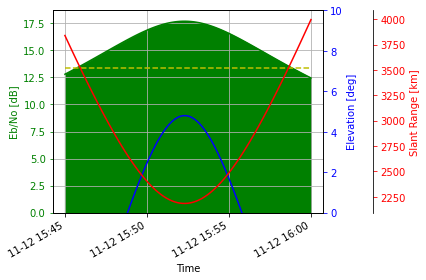

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

k = lp.LinkBudgetKeys
time = [n[k.time] for n in result]
ebno = [n[k.ebno_ratio] for n in result]
ebno_threshold = [n[k.ebno_ratio_threshold] for n in result]
slant_range = [n[k.slant_range]/1000 for n in result]

fig, ax1 = plt.subplots()
ax2, ax3, = ax1.twinx(), ax1.twinx()

ax1.plot(time, ebno, color='g')
ax1.fill_between(time, ebno, 0, color="g")
ax1.plot(time, ebno_threshold, "y--")
ax1.tick_params('y', colors='g')
ax1.set_ylabel("Eb/No [dB]", color="g")
ax1.set_ylim(0, max(filter(None, ebno)) + 1)

ax2.plot(time, elevation, color='b')
ax2.tick_params('y', colors='b')
ax2.set_ylabel("Elevation [deg]", color="b")
ax2.set_ylim(0, 10)

ax3.plot(time, slant_range, color='r')
ax3.tick_params('y', colors='r')
ax3.set_ylabel("Slant Range [km]", color="r")
ax3.spines["right"].set_position(("outward", 50))

ax1.set_xlabel("Time")
ax1.grid(True)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [6]:
result[0]

{<LinkBudgetKeys.time [datetime]>: datetime.datetime(2018, 11, 12, 15, 45),
 <LinkBudgetKeys.tx_amplifier_power [dBW]>: 0,
 <LinkBudgetKeys.tx_circuit_loss [dB]>: 1,
 <LinkBudgetKeys.tx_antenna_angle [deg]>: 0,
 <LinkBudgetKeys.tx_antenna_gain [dBi]>: 0,
 <LinkBudgetKeys.tx_antenna_pointing_loss [dB]>: 0,
 <LinkBudgetKeys.eirp [dBW]>: -1,
 <LinkBudgetKeys.medium_loss [dB]>: 1,
 <LinkBudgetKeys.slant_range [m]>: 3840166.923271932,
 <LinkBudgetKeys.power_flux_density [dBW/m^2]>: -144.67910069153152,
 <LinkBudgetKeys.power_flux_density_limit [dBW/m^2]>: None,
 <LinkBudgetKeys.free_space_path_loss [dB]>: 156.92849849804756,
 <LinkBudgetKeys.total_path_loss [dB]>: 160.92849849804756,
 <LinkBudgetKeys.received_isotropic_signal_level [dB]>: -161.92849849804756,
 <LinkBudgetKeys.rx_antenna_angle [deg]>: 0,
 <LinkBudgetKeys.rx_antenna_gain [dBi]>: 15.5,
 <LinkBudgetKeys.rx_antenna_pointing_loss [dB]>: 0.0,
 <LinkBudgetKeys.rx_circuit_loss [dB]>: 2.0,
 <LinkBudgetKeys.received_power [dBW]>: -148